In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.patches as mpatches


Starting Riccati iLQR iterations...
Iter: 00, Cost: 428.724814, Mu: 1.00e-06
  Line search: gamma = 0.000977, New Cost = 204.9647
Iter: 01, Cost: 204.964682, Mu: 7.00e-07
  Line search: gamma = 0.001953, New Cost = 89.2206
Iter: 02, Cost: 89.220633, Mu: 4.90e-07
  Line search: gamma = 0.000488, New Cost = 62.5569
Iter: 03, Cost: 62.556865, Mu: 3.43e-07
  Line search: gamma = 0.001953, New Cost = 61.2761
Iter: 04, Cost: 61.276094, Mu: 2.40e-07
  Line search: gamma = 0.000977, New Cost = 60.4051
Iter: 05, Cost: 60.405120, Mu: 1.68e-07
  Line search: gamma = 0.000977, New Cost = 58.7297
Iter: 06, Cost: 58.729660, Mu: 1.18e-07
  Line search: gamma = 0.000488, New Cost = 54.2315
Iter: 07, Cost: 54.231499, Mu: 8.24e-08
  Line search: gamma = 0.000977, New Cost = 53.9219
Iter: 08, Cost: 53.921861, Mu: 5.76e-08
  Line search: gamma = 0.000977, New Cost = 53.7384
Iter: 09, Cost: 53.738437, Mu: 4.04e-08
  Line search: gamma = 0.000977, New Cost = 53.5639
Iter: 10, Cost: 53.563925, Mu: 2.82e-08
 

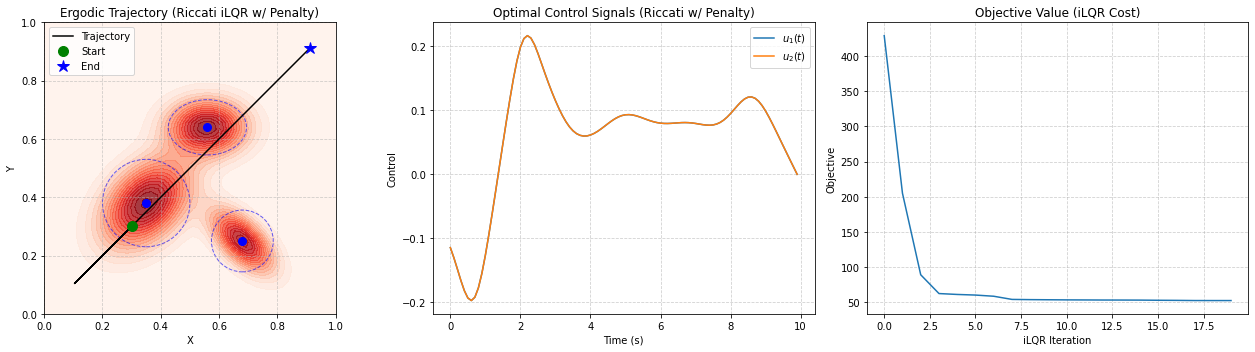

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.patches as mpatches


# --- 1. GMM Parameters and Function ---
w = [0.5, 0.2, 0.3]
mu = [np.array([0.35, 0.38]), np.array([0.68, 0.25]), np.array([0.56, 0.64])]
Sigma = [
    np.array([[0.01, 0.004], [0.004, 0.01]]),
    np.array([[0.005, -0.003], [-0.003, 0.005]]),
    np.array([[0.008, 0.0], [0.0, 0.004]])
]
gaussians = [multivariate_normal(mean=m, cov=s) for m, s in zip(mu, Sigma)]
def gmm_pdf(x):
    pdf_val = 0
    for weight, gauss in zip(w, gaussians):
        pdf_val += weight * gauss.pdf(x)
    return pdf_val

# --- 2. Fourier Basis and Target Coefficients ---
L = 1.0
N_basis = 7
def get_k_vectors(N_basis, dim=2):
    k_vectors = []
    for i in range(N_basis):
        for j in range(N_basis):
            k_vectors.append(np.array([i, j]))
    return np.array(k_vectors)
k_vectors = get_k_vectors(N_basis)
num_k = len(k_vectors)

def F_k(x, k_vec):
    # x = np.clip(x, 0, L)
    return np.prod(np.cos(np.pi * k_vec * x / L))

def grad_F_k(x, k_vec):
    # x = np.clip(x, 0, L)
    grad = np.zeros_like(x, dtype=float)
    k1, k2 = k_vec; x1, x2 = x; pi_L = np.pi / L
    if k1 != 0: grad[0] = -k1 * pi_L * np.sin(k1 * pi_L * x1) * np.cos(k2 * pi_L * x2)
    else: grad[0] = 0
    if k2 != 0: grad[1] = -k2 * pi_L * np.cos(k1 * pi_L * x1) * np.sin(k2 * pi_L * x2)
    else: grad[1] = 0
    return grad

h_k = np.ones(num_k)
grid_size = 50
x_vals = np.linspace(0, L, grid_size); y_vals = np.linspace(0, L, grid_size)
xx, yy = np.meshgrid(x_vals, y_vals)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
pdf_values = gmm_pdf(grid_points)
dA = (L / (grid_size - 1))**2
phi_k = np.zeros(num_k)
for i, k in enumerate(k_vectors):
    F_k_vals = F_k(grid_points, k)
    h_k_grid = np.sqrt(np.sum(F_k_vals**2) * dA)
    h_k[i] = L if h_k_grid < 1e-6 else h_k_grid
    phi_k[i] = np.sum(pdf_values * (F_k_vals / h_k[i])) * dA
s_lambda = 1.5
lambda_k = (1.0 + np.linalg.norm(k_vectors, axis=1)**2)**(-s_lambda)
lambda_k[0] = 0

# --- 3. iLQR Parameters & System Dynamics ---
dt = 0.1
T_horizon = 10.0
tlist = np.arange(0, T_horizon, dt)
tsteps = tlist.shape[0]
x0 = np.array([0.3, 0.3])
init_u_traj = np.zeros((tsteps, 2))

# --- Cost matrices & Scaling --- NEW BOUNDARY PENALTY ---
Q_reg = np.diag([0.01, 0.01])
R_u = np.diag([0.05, 0.05])
Ergodic_Scale = 1000.0
Boundary_Penalty = 5000.0 # Large penalty for going out of bounds

n_state = 2
n_ctrl = 2
A = np.eye(n_state)
B = np.eye(n_ctrl) * dt

def dyn(xt, ut): return ut
# --- IMPORTANT: Keep clipping in step as a 'safety net' ---
def step(xt, ut): return np.clip(xt + dt * dyn(xt, ut), 0, L)

def traj_sim(x0, ulist):
    tsteps_sim = ulist.shape[0]
    x_traj = np.zeros((tsteps_sim + 1, n_state))
    x_traj[0] = x0.copy()
    for t in range(tsteps_sim):
        x_traj[t+1] = step(x_traj[t], ulist[t])
    return x_traj

# --- 4. Ergodic Cost Function & Gradients --- NEW BOUNDARY COST ---
def relu(x): return np.maximum(0, x)

def boundary_cost(xt):
    cost = relu(xt[0] - L)**2 + relu(-xt[0])**2 + \
           relu(xt[1] - L)**2 + relu(-xt[1])**2
    return Boundary_Penalty * cost

def boundary_grad(xt):
    grad = np.array([
        2 * relu(xt[0] - L) - 2 * relu(-xt[0]),
        2 * relu(xt[1] - L) - 2 * relu(-xt[1])
    ])
    return Boundary_Penalty * grad

def boundary_hess(xt):
    hess = np.zeros((2, 2))
    if xt[0] > L or xt[0] < 0: hess[0, 0] = 2.0
    if xt[1] > L or xt[1] < 0: hess[1, 1] = 2.0
    return Boundary_Penalty * hess

def calculate_ck(x_traj):
    ck = np.zeros(num_k)
    N = x_traj.shape[0]
    for xt in x_traj:
        F_k_vals = np.array([F_k(xt, k) / h for k, h in zip(k_vectors, h_k)])
        ck += F_k_vals
    return ck / N

def J_ergodic(x_traj, u_traj):
    x_run = x_traj[:-1]
    ck = calculate_ck(x_run)
    erg_cost = np.sum(lambda_k * (ck - phi_k)**2) * Ergodic_Scale
    ctrl_cost = np.sum([ut.T @ R_u @ ut for ut in u_traj]) * dt
    state_cost = np.sum([xt.T @ Q_reg @ xt for xt in x_run]) * dt
    bound_cost = np.sum([boundary_cost(xt) for xt in x_run]) * dt
    return erg_cost + ctrl_cost + state_cost + bound_cost

def get_cost_grads(x_traj, u_traj):
    N = u_traj.shape[0]
    l_x = np.zeros((N, n_state))
    l_u = np.zeros((N, n_ctrl))
    l_xx = np.zeros((N, n_state, n_state))
    l_uu = np.zeros((N, n_ctrl, n_ctrl))
    l_ux = np.zeros((N, n_ctrl, n_state))

    ck = calculate_ck(x_traj[:-1])
    Ek = ck - phi_k

    for t in range(N):
        xt = x_traj[t]
        ut = u_traj[t]
        grad_Fk_vals = np.array([grad_F_k(xt, k) / h for k, h in zip(k_vectors, h_k)])
        erg_grad_x = np.sum(2.0 * lambda_k[:, np.newaxis] * Ek[:, np.newaxis] * (1.0 / N) * grad_Fk_vals, axis=0) * Ergodic_Scale

        l_x[t] = erg_grad_x + 2 * Q_reg @ xt + boundary_grad(xt) # Add boundary grad
        l_u[t] = 2 * R_u @ ut
        l_xx[t] = 2 * Q_reg + boundary_hess(xt) # Add boundary hessian
        l_uu[t] = 2 * R_u
        l_ux[t] = np.zeros((n_ctrl, n_state))

    return l_x, l_u, l_xx, l_uu, l_ux

# --- 5. Riccati iLQR Implementation (Unchanged) ---
def backward_pass(l_x, l_u, l_xx, l_uu, l_ux, mu_reg):
    N = l_x.shape[0]
    k_list = np.zeros((N, n_ctrl))
    K_list = np.zeros((N, n_ctrl, n_state))
    V_x = np.zeros(n_state)
    V_xx = np.zeros((n_state, n_state))

    for t in range(N - 1, -1, -1):
        Q_x = l_x[t] + A.T @ V_x
        Q_u = l_u[t] + B.T @ V_x
        Q_xx = l_xx[t] + A.T @ V_xx @ A
        Q_uu = l_uu[t] + B.T @ V_xx @ B
        Q_ux = l_ux[t] + B.T @ V_xx @ A
        Q_uu_reg = Q_uu + np.eye(n_ctrl) * mu_reg

        try:
            Q_uu_inv = np.linalg.inv(Q_uu_reg)
        except np.linalg.LinAlgError:
            # print(f"Warning: Q_uu not invertible at t={t}. Increasing mu.")
            mu_reg *= 5.0
            Q_uu_reg = Q_uu + np.eye(n_ctrl) * mu_reg
            Q_uu_inv = np.linalg.inv(Q_uu_reg)

        k_t = -Q_uu_inv @ Q_u
        K_t = -Q_uu_inv @ Q_ux
        k_list[t] = k_t
        K_list[t] = K_t
        V_x = Q_x + K_t.T @ Q_uu @ k_t + K_t.T @ Q_u + Q_ux.T @ k_t
        V_xx = Q_xx + K_t.T @ Q_uu @ K_t + 2 * K_t.T @ Q_ux

    return k_list, K_list, mu_reg

# --- 6. iLQR Iteration Loop --- NEW LINE SEARCH ALPHA ---
def forward_pass(x0, u_traj, k_list, K_list, alpha_base):
    x_old = traj_sim(x0, u_traj)
    cost_old = J_ergodic(x_old, u_traj)

    for gamma_pow in range(15): # Try more steps
        gamma = alpha_base ** gamma_pow
        u_new = np.zeros_like(u_traj)
        x_new = np.zeros_like(x_old)
        x_new[0] = x0
        x_old_run = x_old[:-1]

        for t in range(u_traj.shape[0]):
            delta_x = x_new[t] - x_old_run[t]
            delta_u = gamma * k_list[t] + K_list[t] @ delta_x
            u_new[t] = u_traj[t] + delta_u
            x_new[t+1] = step(x_new[t], u_new[t])

        cost_new = J_ergodic(x_new, u_new)

        if cost_new < cost_old:
            print(f"  Line search: gamma = {gamma:.6f}, New Cost = {cost_new:.4f}")
            return x_new, u_new, True

    print("  Line search failed.")
    return x_old, u_traj, False

print("Starting Riccati iLQR iterations...")
u_traj = init_u_traj.copy()
n_iters = 50
mu_reg = 1e-6
alpha_base = 0.5 # Line search base step reduction
cost_history = []

for iter_num in range(n_iters):
    x_traj = traj_sim(x0, u_traj)
    current_cost = J_ergodic(x_traj, u_traj)
    cost_history.append(current_cost)
    print(f"Iter: {iter_num:02d}, Cost: {current_cost:.6f}, Mu: {mu_reg:.2e}")

    l_x, l_u, l_xx, l_uu, l_ux = get_cost_grads(x_traj, u_traj)
    
    success_bp = False
    temp_mu = mu_reg
    for _ in range(10):
        k_list, K_list, temp_mu_new = backward_pass(l_x, l_u, l_xx, l_uu, l_ux, temp_mu)
        temp_mu = temp_mu_new
        if np.all(np.isfinite(k_list)) and np.all(np.isfinite(K_list)):
             success_bp = True
             break
        else:
             print("Backward pass failed, increasing mu.")
             temp_mu *= 10.0
    
    if not success_bp:
        print("Backward pass failed repeatedly. Stopping.")
        break
        
    mu_reg = temp_mu

    x_traj_new, u_traj_new, success_fp = forward_pass(x0, u_traj, k_list, K_list, alpha_base)

    if success_fp:
        if iter_num > 0 and abs(cost_history[-2] - cost_history[-1]) < 1e-2:
             print("Converged.")
             u_traj = u_traj_new
             break
        u_traj = u_traj_new
        mu_reg = max(1e-8, mu_reg * 0.7)
    else:
        mu_reg = min(1e8, mu_reg * 2.0)
        if mu_reg >= 1e8:
            print("Regularization too high. Stopping.")
            break

print("iLQR complete.")

# --- 7. Plot Final Results ---
x_final_traj = traj_sim(x0, u_traj)

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(131)
ax1.contourf(xx, yy, pdf_values.reshape(xx.shape), levels=20, cmap='Reds', alpha=0.8)
ax1.plot(x_final_traj[:, 0], x_final_traj[:, 1], 'k-', lw=1.5, label='Trajectory')
ax1.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
ax1.plot(x_final_traj[-1, 0], x_final_traj[-1, 1], 'b*', markersize=12, label='End')
for i, m in enumerate(mu):
    ax1.plot(m[0], m[1], 'bo', markersize=8)

ax1.set_title('Ergodic Trajectory (Riccati iLQR w/ Penalty)')
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_xlim(0, L); ax1.set_ylim(0, L)
ax1.set_aspect('equal', adjustable='box'); ax1.legend(); ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = fig.add_subplot(132)
ax2.plot(tlist, u_traj[:, 0], label='$u_1(t)$'); ax2.plot(tlist, u_traj[:, 1], label='$u_2(t)$')
ax2.set_title('Optimal Control Signals (Riccati w/ Penalty)'); ax2.set_xlabel('Time (s)'); ax2.set_ylabel('Control')
ax2.legend(); ax2.grid(True, linestyle='--', alpha=0.6)

ax3 = fig.add_subplot(133)
ax3.plot(range(len(cost_history)), cost_history)
ax3.set_title('Objective Value (iLQR Cost)'); ax3.set_xlabel('iLQR Iteration'); ax3.set_ylabel('Objective')
ax3.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()